## COVID-19 data analysis

<img src=coronavirus-DNA-720.png  width="1200" >

In [1]:
#see online at https://covid19-jyy3.onrender.com

#libraries
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.dates import date2num
import gc
plt.style.use('ggplot')

# Load Global Dataset

In [2]:
#Download world dataset
!curl https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv -o deaths_global.csv 
allDf = pd.read_csv('deaths_global.csv')
allDf.head()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55150  100 55150    0     0   104k      0 --:--:-- --:--:-- --:--:--  104k


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,7,7,11,14,14,15,15,18,18,21
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,20,20,21,22,22,23,23,23,23,23
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,130,152,173,193,205,235,256,275,293,313
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,17,18,21,22,23,25,26,26,29,29
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [3]:
#keep Italian repository update
!git pull https://github.com/pcm-dpc/COVID-19.git master --no-edit

remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 16 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (16/16), done.
From https://github.com/pcm-dpc/COVID-19
 * branch            master     -> FETCH_HEAD
Auto-merging aree/shp/COVID19_AREE.dbf
Merge made by the 'recursive' strategy.
 .../{dpc-covid-19-ita-aree.dbf => COVID19_AREE.dbf} | Bin 42506 -> 43539 bytes
 metadata/covid-19-aree.xml                          |  10 +++++-----
 2 files changed, 5 insertions(+), 5 deletions(-)
 rename aree/shp/{dpc-covid-19-ita-aree.dbf => COVID19_AREE.dbf} (97%)


# Load National Dataset

In [4]:
df = pd.read_csv(os.path.join('dati-andamento-nazionale',
                               'dpc-covid19-ita-andamento-nazionale.csv'))
df.data = pd.to_datetime(df.data)
#assuming terapia_intensiva (intensive care) and deceduti (deaths)
#are cumulative. It is not specified in the dataset.
#Computing Daily new cases
df['ricoverati_con_sintomi_change']=df['ricoverati_con_sintomi']-df['ricoverati_con_sintomi'].shift(1)
df['terapia_intensiva_change']=df['terapia_intensiva']-df['terapia_intensiva'].shift(1)
df['deceduti_daily']=df['deceduti']-df['deceduti'].shift(1)


#The number of deaths over the number 
#of new cases admitted in intensive care (daily)
df['not_admitted_ratio'] = df['deceduti_daily']/(df['terapia_intensiva_change'])
#The number of deaths minus the number 
#of new cases admitted in intensive care (daily)
df['not_admitted'] = df['deceduti_daily']-(df['terapia_intensiva_change'])

#remove unused
df.drop(['stato'],axis=1,inplace=True)
df.drop(['data'],axis=1).tail()

#compute log of selected columns
cols = ['nuovi_positivi',#new positive case now
          'deceduti_daily',#today deaths
          'terapia_intensiva',#Intensive care
          'deceduti'#deaths
         ]
for c in cols:
    
    df[c+'_log']=np.log10(df[c])
df[cols+['deceduti_daily_log']].head(5)

,nuovi_positivi,deceduti_daily,terapia_intensiva,deceduti,deceduti_daily_log
0,221,NaN,26,7,NaN
1,93,3.0,35,10,0.477121
2,78,2.0,36,12,0.301030
3,250,5.0,56,17,0.698970
4,238,4.0,64,21,0.602060


# Fig1 
How the death rate changes before and after the introduction of social distancing mesures in Italy?

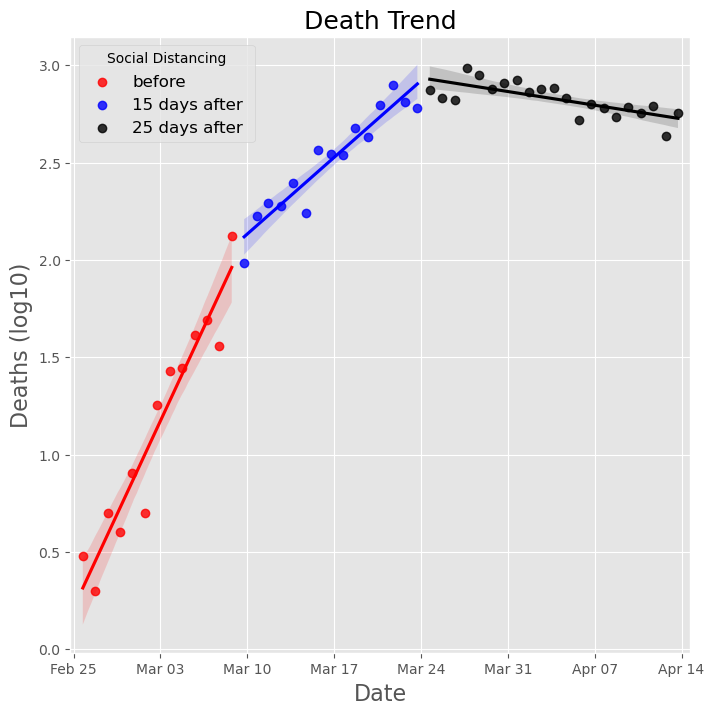

In [23]:
make_fig1()

# Fig2 
How many more people die in Italy respect to the people admitted in intensive care?

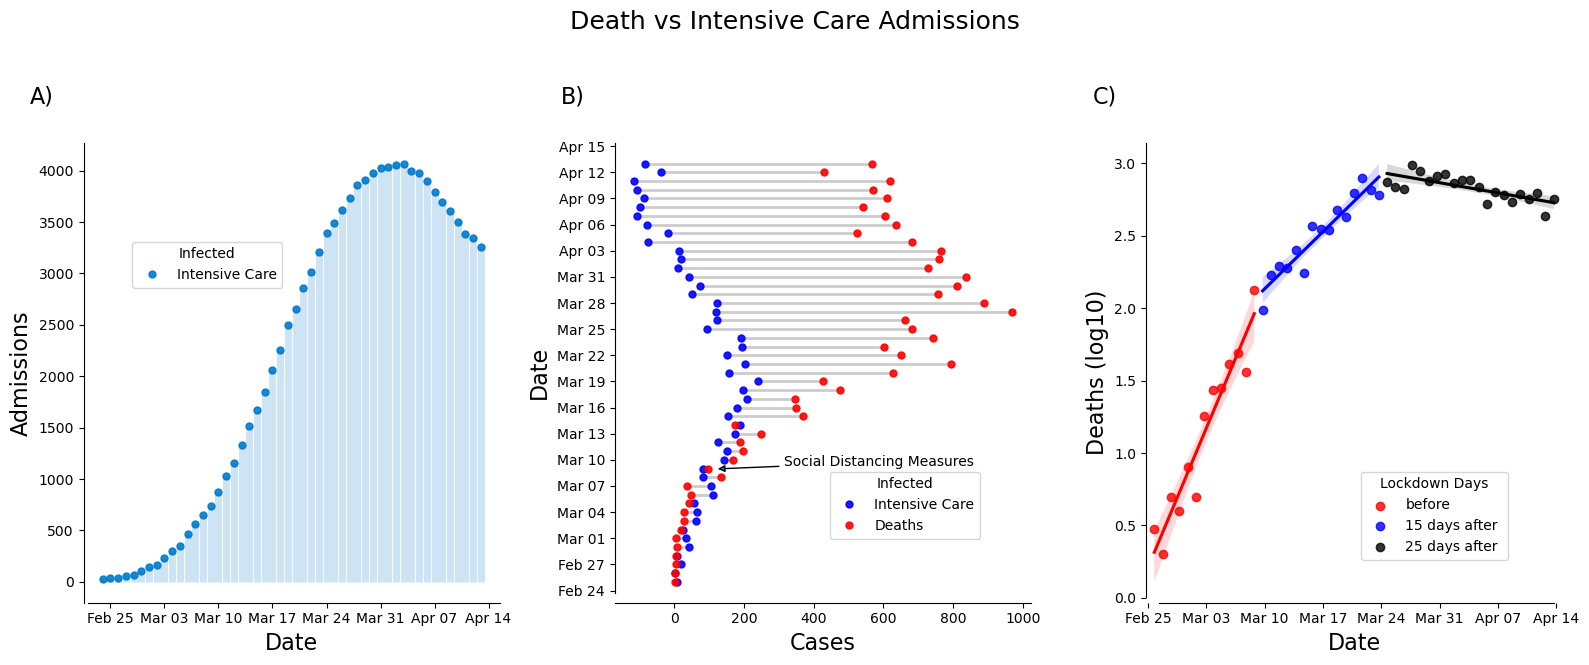

In [40]:
make_fig2()

# Fig3
How UK deaths compare to Italy and Spain

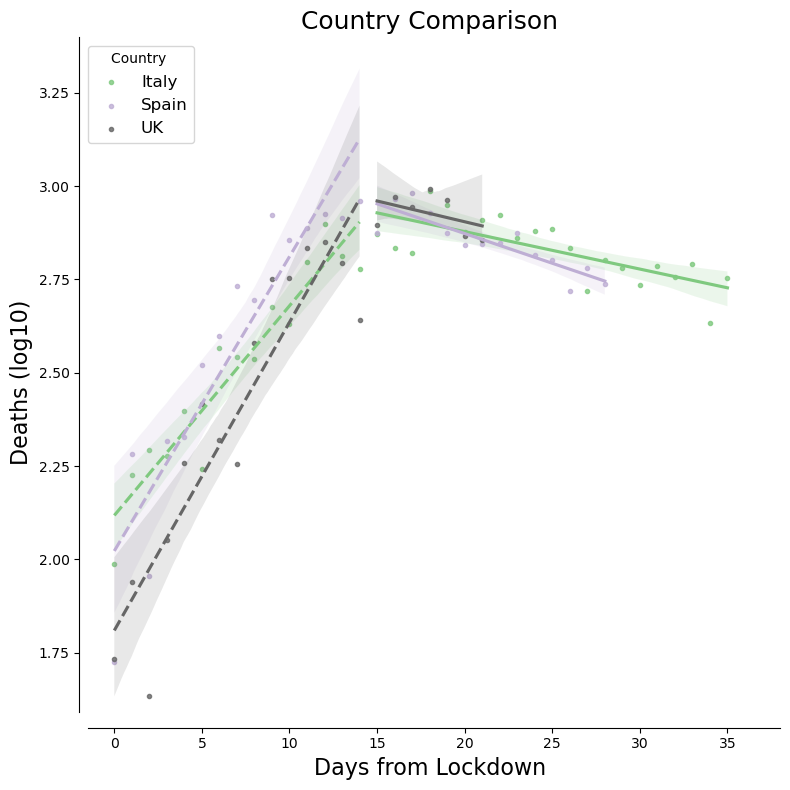

In [37]:
make_fig3()

# code

In [39]:
#suppress annoying warnings about pandas assignment
pd.options.mode.chained_assignment = None
#suppress all warnings
import warnings
warnings.filterwarnings("ignore")
#format x axis with dates
def format_x_date(ax):
    #set ticks every week
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))


def get_country_data(selection):
    selection = selection.iloc[:,4:].T
    selection.columns=['Death']
    selection['Death_change']=selection['Death']-selection['Death'].shift(1)
    selection=selection.reset_index()
    selection['index'] = pd.to_datetime(selection['index'])
    selection['Death_change_log']=np.log10(selection['Death_change'])
    selection['Death_change_log']=selection['Death_change_log'].replace(-np.inf,np.nan)
    selection=selection[~selection['Death_change_log'].isna()]
    selection.columns=['date']+list(selection.columns[1:])
    selection['ndate']=date2num(selection['date'])
    return selection

def make_fig1():
    plt.style.use('ggplot')
    before = df[df['data']<'2020-03-9']
    before['ndata']=date2num(before['data'])
    after = df[(df['data']>'2020-03-9') & (df['data']<'2020-03-24') ]
    after['ndata']=date2num(after['data'])

    after2 = df[(df['data']>='2020-03-24')  ]
    after2['ndata']=date2num(after2['data'])

    x='ndata'
    y='deceduti_daily_log'
    fig,ax=plt.subplots(figsize=(8,8))
    sns.regplot(x=x, y=y, color="r", data=before,ax=ax,label='before')
    sns.regplot(x=x, y=y, color="b", data=after,ax=ax,label='15 days after ')
    sns.regplot(x=x, y=y, color="black", data=after2,ax=ax,label='25 days after')
    format_x_date(ax)
    xmin, xmax = ax.get_xlim()
    ax.set_xlim(xmin-1,xmax+1)
    #plt.xticks(rotation=70,ha='right')
    plt.xlabel('Date', fontsize='16')
    plt.ylabel('Deaths (log10)',fontsize='16')
    plt.title('Death Trend',fontsize='18')
    plt.legend(title='Social Distancing',fontsize=12)
    plt.savefig('Fig1.png')
    plt.show()
    
    
#plt.style.use('ggplot')

def despine(ax,log_y=False):
    small_add=1.1   
    ymin, ymax = ax.get_ylim()
    if log_y:
        small_add = np.log10(small_add) 
    #print(ymin, ymax)
    #print(small_add)
    #ax.set_ylim(ymin+small_add,ymax)

    ax.spines['left'].set_bounds(ymin+small_add, ymax)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    xmin, xmax = ax.get_xlim()
    #ax.set_xlim(xmin,xmax)

    ax.spines['bottom'].set_bounds(xmin+0.5, xmax)
    
def lollipop_plot(df, ax, date_col='data', value_col='not_admitted_ratio',
                 color='#007acc',label='Ratio'):
    #make lollipop
    ax.plot(df[date_col].dt.date, df[value_col], "o",
        markersize=5, color=color, alpha=0.9,label=label)
    #make stick
    ax.vlines(x=df[date_col].dt.date, ymin=0, 
          ymax=df[value_col], color=color, alpha=0.2, linewidth=5)

    #set ticks every week
    despine(ax)
    format_x_date(ax)
    
    return ax

def my_plot(df, ax, date_col='data', 
            #value_3='ricoverati_con_sintomi_change',
            value_2='terapia_intensiva_change',
            value_1='deceduti_daily',
            
            label_1='Deaths',
            label_2="Intensive Care",
            #label_3="Hospital Admissions",
           ):
    #make lollipop
    #ax.plot(df[value_3], df[date_col].dt.date, "o",
    #    markersize=5, color='green', alpha=0.9,label=label_3)    
    ax.plot(df[value_2], df[date_col].dt.date, "o",
        markersize=5, color='blue', alpha=0.9,label=label_2)
    ax.plot(df[value_1], df[date_col].dt.date, "o",
        markersize=5, color='red', alpha=0.9,label=label_1)

    
    xmin=df[[value_1,value_2]].min(axis=1)
    xmax=df[[value_1,value_2]].max(axis=1)
    #make stick
    ax.hlines(y=df[date_col].dt.date, xmin=xmin,
              xmax=xmax, color='black', alpha=0.2, linewidth=2)

    
    #ymin, ymax = ax.get_ylim()
    #ax.set_ylim(ymin,ymax)
    #ax.spines['left'].set_bounds(ymin, ymax-0.5)
    despine(ax)
    #set ticks every 3 days
    #ax.yaxis.set_major_locator(mdates.WeekdayLocator())
    ax.yaxis.set_major_locator(mdates.DayLocator(interval=3))
    #set major ticks format
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

    #ax.spines['top'].set_color('none')
    #ax.spines['right'].set_color('none')
    #xmin, xmax = ax.get_xlim()
    #ax.spines['bottom'].set_bounds(0, xmax-1)
    return ax

def make_fig2():
    plt.style.use('default')
    from matplotlib.patches import Ellipse

    fig,axes=plt.subplots(figsize=(16,6
                                  ),ncols=3)

    ax=axes[1]
    ax = my_plot(df, ax)
    df['ndate']=date2num(df['data'])

    ax.set_xlabel('Cases', fontsize='16')
    ax.set_ylabel('Date', fontsize='16')

    ax.annotate('Social Distancing Measures', 
                (df['deceduti_daily'][14]+20, mdates.date2num(df['data'][13])+0.2 ),
                xytext=(50, 2), 
                textcoords='offset points', 
                arrowprops=dict(arrowstyle='-|>'))
    ax.text(-0.1, 1.1, 'B)', horizontalalignment='center', 
                   verticalalignment='center',
                   transform=ax.transAxes,fontsize=16)

    ax.legend(loc=2, bbox_to_anchor=(0.5, 0.3), title='Infected')
    ax=axes[0]
    ax = lollipop_plot(df, ax, date_col='data',
                       value_col='terapia_intensiva',label='Intensive Care')

    ax.legend(loc=2, bbox_to_anchor=(0.1, 0.8), title='Infected')

    ax.set_xlabel('Date', fontsize='16')
    ax.set_ylabel('Admissions', fontsize='16')
    ax.text(-0.1, 1.1, 'A)', horizontalalignment='center', 
                   verticalalignment='center',
                   transform=ax.transAxes,fontsize=16)


    ax=axes[2]
    before = df[df['data']<'2020-03-9']
    before['ndata']=date2num(before['data'])
    after = df[(df['data']>'2020-03-9') & (df['data']<'2020-03-24') ]
    after['ndata']=date2num(after['data'])

    after2 = df[(df['data']>='2020-03-24')  ]
    after2['ndata']=date2num(after2['data'])

    x='ndata'
    y='deceduti_daily_log'
    #fig,ax=plt.subplots(figsize=(8,8))
    sns.regplot(x=x, y=y, color="r", data=before,ax=ax,label='before')
    sns.regplot(x=x, y=y, color="b", data=after,ax=ax,label='15 days after ')
    sns.regplot(x=x, y=y, color="black", data=after2,ax=ax,label='25 days after')


    despine(ax,log_y=True)
    format_x_date(ax)
    xmin, xmax = ax.get_xlim()
    ax.set_xlim(xmin-1,xmax+1)


    ax.set_xlabel('Date', fontsize='16')
    ax.set_ylabel('Deaths (log10)',fontsize='16')
    ax.text(-0.1, 1.1, 'C)', horizontalalignment='center', 
                   verticalalignment='center',
                   transform=ax.transAxes,fontsize=16)

    plt.tight_layout()
    ax.legend(loc=2, bbox_to_anchor=(0.5, 0.3), title='Lockdown Days')
    plt.suptitle('Death vs Intensive Care Admissions',fontsize='18',y=1.1)
    plt.savefig('Fig2.png')
    plt.show()

def make_fig3():
    plt.style.use('default')
    #sns.palplot(sns.color_palette("Accent"))
    palette=sns.color_palette("Accent")
    days_after_lock=15

    fig,ax=plt.subplots(figsize=(8,8))
    temp = df[df['data']>'2020-03-9']
    temp['days_from_lockdown']=np.arange(0,df[df['data']>'2020-03-9'].shape[0])

    sns.regplot(x='days_from_lockdown',y='deceduti_daily_log'
                ,data=temp.iloc[0:days_after_lock],fit_reg=True,color=palette[0],
               marker='.',line_kws={'linestyle':'--'}) 
    sns.regplot(x='days_from_lockdown',y='deceduti_daily_log',
                data=temp.iloc[days_after_lock:],fit_reg=True,color=palette[0],
                label='Italy',marker='.') 


    spain_df = allDf[(allDf['Country/Region']=='Spain')]
    spain_df =  get_country_data(spain_df)
    spain_df = spain_df[spain_df['date']>='2020-03-16']
    spain_df['days_from_lockdown']=np.arange(0,spain_df.shape[0])


    sns.regplot(x='days_from_lockdown',y='Death_change_log'
                ,data=spain_df.iloc[0:days_after_lock],fit_reg=True,color=palette[1],
                marker='.',line_kws={'linestyle':'--'}) 
    sns.regplot(x='days_from_lockdown',y='Death_change_log',
                data=spain_df.iloc[days_after_lock:],fit_reg=True,color=palette[1],
                label='Spain',marker='.') 


    uk_df = allDf[(allDf['Country/Region']=='United Kingdom') & (allDf['Lat']==55.3781)  ]
    uk_df =  get_country_data(uk_df) 
    uk_df = uk_df[uk_df['date']>='2020-03-23']
    uk_df['days_from_lockdown']=np.arange(0,uk_df.shape[0])


    sns.regplot(x='days_from_lockdown',y='Death_change_log'
                ,data=uk_df.iloc[0:days_after_lock],fit_reg=True,color=palette[-1],marker='.',
               line_kws={'linestyle':'--'}) 
    sns.regplot(x='days_from_lockdown',y='Death_change_log',
                data=uk_df.iloc[days_after_lock:],fit_reg=True,color=palette[-1],label='UK',marker='.') 





    ax.set_xlim(-2,temp.shape[0]+2)
    ax.set_ylabel('Deaths (log10)',fontsize='16')
    ax.set_xlabel('Days from Lockdown',fontsize='16')
    ax.legend(title='Country ',fontsize=12,loc=2)
    
    despine(ax,log_y=True)
    plt.title('Country Comparison',fontsize='18')
    plt.tight_layout()
    plt.savefig('Fig3.png')
#format_x_date(ax)

In [16]:
!jupyter nbconvert --to html_toc DataVis.ipynb

[NbConvertApp] Converting notebook DataVis.ipynb to html_toc
[NbConvertApp] Support files will be in DataVis_files/
[NbConvertApp] Making directory DataVis_files
[NbConvertApp] Making directory DataVis_files
[NbConvertApp] Making directory DataVis_files
[NbConvertApp] Writing 351121 bytes to DataVis.html


In [17]:
!git add DataVis*
!git add Fig**
!git add -u
!git commit -m 'move cells'
!git push -u origin master

[master ba11abd] move cells
 9 files changed, 1571 insertions(+), 1459 deletions(-)
 rewrite DataVis.ipynb (88%)
 create mode 100644 DataVis_files/DataVis_10_1.png
 create mode 100644 DataVis_files/DataVis_12_1.png
 rewrite DataVis_files/DataVis_8_0.png (99%)
 rewrite Fig1.png (99%)
 rewrite Fig2.png (97%)
 rewrite Fig3.png (98%)
Counting objects: 31, done.
Delta compression using up to 8 threads.
Compressing objects: 100% (31/31), done.
Writing objects: 100% (31/31), 641.63 KiB | 0 bytes/s, done.
Total 31 (delta 15), reused 0 (delta 0)
remote: Resolving deltas: 100% (15/15), completed with 6 local objects.
To https://github.com/mtinti/COVID-19.git
   ac4e54a..ba11abd  master -> master
Branch master set up to track remote branch master from origin.
